References
https://www.analyticsvidhya.com/blog/2017/03/imbalanced-classification-problem/

https://www.kaggle.com/qianchao/smote-with-imbalance-data

https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/

https://beckernick.github.io/oversampling-modeling/

https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

Informed over sampling

Advantages

- Mitigates the problem of overfitting caused by random oversampling as synthetic examples are generated rather than replication of instances
- No loss of useful information


Disadvantages

- While generating synthetic examples SMOTE does not take into consideration neighboring examples from other classes. This can result in increase in overlapping of classes and can introduce additional noise

- SMOTE is not very effective for high dimensional data

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

# for LR
import statsmodels.api as sm
from sklearn.model_selection import KFold
import random

# for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


# for Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

# svm
from sklearn import svm
from sklearn.metrics import confusion_matrix

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Read Clean Data

In [3]:
%%time
clean_train_data = pd.read_csv('/Users/josephcolaco/customer_revenue_prediction/data/cleaned_feat_eng_train_data.csv', 
                        dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, nrows=None)
clean_test_data = pd.read_csv('/Users/josephcolaco/customer_revenue_prediction/data/cleaned_feat_eng_test_data.csv', 
                        dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, nrows=None)
print('Shape of train data is',clean_train_data.shape)
print('Shape of test data is',clean_test_data.shape)

Shape of train data is (902755, 178)
Shape of test data is (803863, 175)
CPU times: user 39.3 s, sys: 4.04 s, total: 43.4 s
Wall time: 42.2 s


In [4]:
sample_submission = pd.read_csv('/Users/josephcolaco/customer_revenue_prediction/data/sample_submission.csv', 
                        dtype={'date': str, 'fullVisitorId': str}, nrows=None)

In [5]:
print('The number of unique customers in the train data are:', clean_train_data['fullVisitorId'].nunique())
print('The number of unique customers in the test data are:', clean_test_data['fullVisitorId'].nunique())
print('The number of unique customers in the sample submission data are:', 
      sample_submission['fullVisitorId'].nunique())

The number of unique customers in the train data are: 714167
The number of unique customers in the test data are: 617242
The number of unique customers in the sample submission data are: 617242


In [6]:
diff_cols = set(clean_train_data.columns).difference(set(clean_test_data.columns))
diff_cols

{'campaignCode', 'logtransactionRevenue', 'madePurchase'}

In [7]:
clean_train_data = clean_train_data.drop(columns=['campaignCode'])

In [49]:
clean_test_data.head()

,Unnamed: 0,channelGrouping,fullVisitorId,sessionId,visitNumber,deviceCategory,isMobile,continent,bounces,hits,newVisits,pageviews,adNetworkType,isVideoAd,page,slot,visitHour,dayNameDate,monthDate,yearDate,dayDate,domain_(not_set),domain_.us,domain_.net,domain_.com,domain_.edu,domain_.ca,domain_.org,domain_.mx,os_Chrome OS,os_Macintosh,os_Linux,os_iOS,os_Windows,adContent_Google Merchandise Collection,adContent_(not_set),browser_Chrome,browser_Firefox,browser_Internet Explorer,browser_Edge,country_United States,country_Venezuela,country_Puerto Rico,country_Canada,city_Maracaibo,city_Ann Arbor,city_Cambridge,city_San Bruno,city_Chicago,city_Austin,city_Irvine,city_New York,city_Nashville,city_Jersey City,city_Boulder,city_Kirkland,city_Seattle,city_Oakland,city_Denver,city_Sunnyvale,city_San Francisco,city_Pittsburgh,city_Washington,city_Atlanta,city_Los Angeles,city_Mountain View,city_Minneapolis,city_San Antonio,city_Lake Oswego,city_Santa Clara,city_Cupertino,city_Salem,city_San Mateo,city_San Diego,city_Palo Alto,city_Fremont,city_Houston,city_Milpitas,city_Boston,city_Charlotte,city_San Jose,city_Philadelphia,city_Redwood City,city_Portland,city_Phoenix,city_(not_set),city_Toronto,city_Dallas,subContinent_Northern America,subContinent_Caribbean,campaign_AW - Dynamic Search Ads Whole Site,campaign_AW - Accessories,campaign_(not_set),region_Zulia,region_Nebraska,region_Michigan,region_Pichincha,region_Tennessee,region_Illinois,region_New York,region_Washington,region_Massachusetts,region_Colorado,region_South Carolina,region_Texas,region_Georgia,region_Missouri,region_Iowa,region_District of Columbia,region_California,region_Minnesota,region_Utah,region_Arizona,region_Pennsylvania,region_New Jersey,region_Indiana,region_Florida,region_Maryland,region_Connecticut,region_North Carolina,region_Virginia,region_Nevada,region_Ohio,region_Alberta,region_(not_set),region_Ontario,region_Oregon,source_mall.googleplex.com,source_dealspotr.com,source_mail.google.com,source_groups.google.com,source_phandroid.com,source_gdeals.googleplex.com,source_dfa,source_l.facebook.com,source_yahoo,source_google,source_bing,source_sites.google.com,source_(direct),source_facebook.com,referralPath_deal,referralPath_sign,referralPath_google,referralPath_merchandise,referralPath_store,referralPath_emails,referralPath_special,referralPath_coup,referralPath_stor,referralPath_mail,referralPath_com,referralPath_forum,referralPath_merch,referralPath_new,referralPath_url,referralPath_site,referralPath_mountain,referralPath_view,referralPath_php,referralPath_offer,referralPath_googletopia,referralPath_free,referralPath_stuff,referralPath_alphabet,referralPath_discount,keyword_qehscssdk,keyword_googl,keyword_merchandis,keyword_store,keyword_hzbaqlcbjwfgoh,keyword_remarket,keyword_content,keyword_target,keyword_zknv
0,0,Organic Search,6167871330617112363,6167871330617112363_1508151024,2,desktop,False,Asia,0,4,0,4,(not_set),1,0,(not_set),10,Monday,10,2017,16,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,Organic Search,0643697640977915618,0643697640977915618_1508175522,1,desktop,False,Europe,0,5,1,5,(not_set),1,0,(not_set),17,Monday,10,2017,16,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,Organic Search,6059383810968229466,6059383810968229466_1508143220,1,desktop,False,Europe,0,7,1,7,(not_set),1,0,(not_set),8,Monday,10,2017,16,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [50]:
clean_test_data['isMobile'] = clean_test_data['isMobile'].astype('int64')

In [51]:
test_id_col = clean_test_data['fullVisitorId']
clean_test_data_v1 = clean_test_data.drop(columns = ['fullVisitorId', 'sessionId', 'Unnamed: 0'])

In [52]:
clean_test_data_v2 = pd.get_dummies(clean_test_data_v1)

In [53]:
clean_test_data_v3 = pd.concat([test_id_col, clean_test_data_v2], axis = 1)

In [54]:
clean_test_data_agg = (clean_test_data_v3.groupby(['fullVisitorId']).agg('sum'))

In [55]:
clean_test_data_agg = clean_test_data_agg.reset_index()
clean_test_data_agg = clean_test_data_agg.drop(columns=['visitNumber', 'visitHour'])
clean_test_data_agg.head()

,fullVisitorId,isMobile,bounces,hits,newVisits,pageviews,isVideoAd,page,monthDate,yearDate,dayDate,domain_(not_set),domain_.us,domain_.net,domain_.com,domain_.edu,domain_.ca,domain_.org,domain_.mx,os_Chrome OS,os_Macintosh,os_Linux,os_iOS,os_Windows,adContent_Google Merchandise Collection,adContent_(not_set),browser_Chrome,browser_Firefox,browser_Internet Explorer,browser_Edge,country_United States,country_Venezuela,country_Puerto Rico,country_Canada,city_Maracaibo,city_Ann Arbor,city_Cambridge,city_San Bruno,city_Chicago,city_Austin,city_Irvine,city_New York,city_Nashville,city_Jersey City,city_Boulder,city_Kirkland,city_Seattle,city_Oakland,city_Denver,city_Sunnyvale,city_San Francisco,city_Pittsburgh,city_Washington,city_Atlanta,city_Los Angeles,city_Mountain View,city_Minneapolis,city_San Antonio,city_Lake Oswego,city_Santa Clara,city_Cupertino,city_Salem,city_San Mateo,city_San Diego,city_Palo Alto,city_Fremont,city_Houston,city_Milpitas,city_Boston,city_Charlotte,city_San Jose,city_Philadelphia,city_Redwood City,city_Portland,city_Phoenix,city_(not_set),city_Toronto,city_Dallas,subContinent_Northern America,subContinent_Caribbean,campaign_AW - Dynamic Search Ads Whole Site,campaign_AW - Accessories,campaign_(not_set),region_Zulia,region_Nebraska,region_Michigan,region_Pichincha,region_Tennessee,region_Illinois,region_New York,region_Washington,region_Massachusetts,region_Colorado,region_South Carolina,region_Texas,region_Georgia,region_Missouri,region_Iowa,region_District of Columbia,region_California,region_Minnesota,region_Utah,region_Arizona,region_Pennsylvania,region_New Jersey,region_Indiana,region_Florida,region_Maryland,region_Connecticut,region_North Carolina,region_Virginia,region_Nevada,region_Ohio,region_Alberta,region_(not_set),region_Ontario,region_Oregon,source_mall.googleplex.com,source_dealspotr.com,source_mail.google.com,source_groups.google.com,source_phandroid.com,source_gdeals.googleplex.com,source_dfa,source_l.facebook.com,source_yahoo,source_google,source_bing,source_sites.google.com,source_(direct),source_facebook.com,referralPath_deal,referralPath_sign,referralPath_google,referralPath_merchandise,referralPath_store,referralPath_emails,referralPath_special,referralPath_coup,referralPath_stor,referralPath_mail,referralPath_com,referralPath_forum,referralPath_merch,referralPath_new,referralPath_url,referralPath_site,referralPath_mountain,referralPath_view,referralPath_php,referralPath_offer,referralPath_googletopia,referralPath_free,referralPath_stuff,referralPath_alphabet,referralPath_discount,keyword_qehscssdk,keyword_googl,keyword_merchandis,keyword_store,keyword_hzbaqlcbjwfgoh,keyword_remarket,keyword_content,keyword_target,keyword_zknv,channelGrouping_(Other),channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,deviceCategory_desktop,deviceCategory_mobile,deviceCategory_tablet,continent_(not_set),continent_Africa,continent_Americas,continent_Asia,continent_Europe,continent_Oceania,adNetworkType_(not_set),adNetworkType_Content,adNetworkType_Google Search,adNetworkType_Search partners,slot_(not_set),slot_Google Display Network,slot_RHS,slot_Top,dayNameDate_Friday,dayNameDate_Monday,dayNameDate_Saturday,dayNameDate_Sunday,dayNameDate_Thursday,dayNameDate_Tuesday,dayNameDate_Wednesday
0,0000000259678714014,0,0,19,1,13,2,0,22,4034,56,2,0,0,0,0,0,0,0,0,2,0,0,0,0,2,2,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
1,0000049363351866189,0,3,3,1,3,3,0,27,6051,55,3,0,0,0,0,0,0,0,3,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

# Data Modeling

### Minimal Prepping for Modeling

- Remove sessionId, Unnamed: 0 and fullVisitorId (removed to get dummies) columns
- Re-attach fullVisitorId column to the data and aggregate it by fullVisitorId
- Remove unwanted aggregated columns

In [8]:
clean_train_data.isnull().sum().sum()

0

In [9]:
id_col = clean_train_data['fullVisitorId']
clean_train_data_v1 = clean_train_data.drop(columns = ['fullVisitorId', 'sessionId', 'Unnamed: 0'])

In [10]:
clean_train_data_v2 = pd.get_dummies(clean_train_data_v1)

In [11]:
clean_train_data_v2['isMobile'] = clean_train_data_v2['isMobile'].astype('int64')

In [12]:
clean_train_data_v2.shape

(902755, 198)

In [13]:
nulls = pd.DataFrame(clean_train_data_v2.isnull().sum(), columns =['null_counts'])
nulls = nulls.sort_values(by ='null_counts', ascending=False)
nulls[nulls['null_counts']>0]

,null_counts


In [14]:
clean_train_data_v2.shape

(902755, 198)

In [15]:
clean_train_data_v2.head()

,visitNumber,isMobile,bounces,hits,newVisits,pageviews,isVideoAd,page,visitHour,logtransactionRevenue,madePurchase,monthDate,yearDate,dayDate,domain_(not_set),domain_.us,domain_.net,domain_.com,domain_.edu,domain_.ca,domain_.org,domain_.mx,os_Chrome OS,os_Macintosh,os_Linux,os_iOS,os_Windows,adContent_Google Merchandise Collection,adContent_(not_set),browser_Chrome,browser_Firefox,browser_Internet Explorer,browser_Edge,country_United States,country_Venezuela,country_Puerto Rico,country_Canada,city_Maracaibo,city_Ann Arbor,city_Cambridge,city_San Bruno,city_Chicago,city_Austin,city_Irvine,city_New York,city_Nashville,city_Jersey City,city_Boulder,city_Kirkland,city_Seattle,city_Oakland,city_Denver,city_Sunnyvale,city_San Francisco,city_Pittsburgh,city_Washington,city_Atlanta,city_Los Angeles,city_Mountain View,city_Minneapolis,city_San Antonio,city_Lake Oswego,city_Santa Clara,city_Cupertino,city_Salem,city_San Mateo,city_San Diego,city_Palo Alto,city_Fremont,city_Houston,city_Milpitas,city_Boston,city_Charlotte,city_San Jose,city_Philadelphia,city_Redwood City,city_Portland,city_Phoenix,city_(not_set),city_Toronto,city_Dallas,subContinent_Northern America,subContinent_Caribbean,campaign_AW - Dynamic Search Ads Whole Site,campaign_AW - Accessories,campaign_(not_set),region_Zulia,region_Nebraska,region_Michigan,region_Pichincha,region_Tennessee,region_Illinois,region_New York,region_Washington,region_Massachusetts,region_Colorado,region_South Carolina,region_Texas,region_Georgia,region_Missouri,region_Iowa,region_District of Columbia,region_California,region_Minnesota,region_Utah,region_Arizona,region_Pennsylvania,region_New Jersey,region_Indiana,region_Florida,region_Maryland,region_Connecticut,region_North Carolina,region_Virginia,region_Nevada,region_Ohio,region_Alberta,region_(not_set),region_Ontario,region_Oregon,source_mall.googleplex.com,source_dealspotr.com,source_mail.google.com,source_groups.google.com,source_phandroid.com,source_gdeals.googleplex.com,source_dfa,source_l.facebook.com,source_yahoo,source_google,source_bing,source_sites.google.com,source_(direct),source_facebook.com,referralPath_deal,referralPath_sign,referralPath_google,referralPath_merchandise,referralPath_store,referralPath_emails,referralPath_special,referralPath_coup,referralPath_stor,referralPath_mail,referralPath_com,referralPath_forum,referralPath_merch,referralPath_new,referralPath_url,referralPath_site,referralPath_mountain,referralPath_view,referralPath_php,referralPath_offer,referralPath_googletopia,referralPath_free,referralPath_stuff,referralPath_alphabet,referralPath_discount,keyword_qehscssdk,keyword_googl,keyword_merchandis,keyword_store,keyword_hzbaqlcbjwfgoh,keyword_remarket,keyword_content,keyword_target,keyword_zknv,channelGrouping_(Other),channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,deviceCategory_desktop,deviceCategory_mobile,deviceCategory_tablet,continent_(not_set),continent_Africa,continent_Americas,continent_Asia,continent_Europe,continent_Oceania,adNetworkType_(not_set),adNetworkType_Google Search,adNetworkType_Search partners,slot_(not_set),slot_RHS,slot_Top,dayNameDate_Friday,dayNameDate_Monday,dayNameDate_Saturday,dayNameDate_Sunday,dayNameDate_Thursday,dayNameDate_Tuesday,dayNameDate_Wednesday
0,1,0,1,1,1,1,1,0,15,0.0,0,9,2016,2,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
1,1,0,1,1,1,1,1,0,5,0.0,0,9,2016,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,

In [16]:
clean_train_data_v3 = pd.concat([id_col, clean_train_data_v2], axis = 1)
clean_train_data_agg = (clean_train_data_v3
                        .groupby(['fullVisitorId'])
                        .agg({'visitNumber': 'count',
                             'isMobile': 'sum',
                             'bounces': 'sum',
                             'hits': 'sum',
                             'newVisits': 'sum', 
                             'pageviews': 'sum',
                             'isVideoAd': 'sum',
                             'page': 'sum',
                             'visitHour': 'mean',
                             'logtransactionRevenue': 'sum',
                             'madePurchase': 'sum'})
                        .rename(columns={'madePurchase':'numMadePurchase',
                                        'logtransactionRevenue': 'sumLogTransactionRevenue'})
                       .reset_index()
                       )

clean_train_data_agg['madePurchase'] = np.where(clean_train_data_agg.numMadePurchase>0, 1, 0)
print('Shape of agg data:', clean_train_data_agg.shape)
clean_train_data_agg.head()

Shape of agg data: (714167, 13)


,fullVisitorId,visitNumber,isMobile,bounces,hits,newVisits,pageviews,isVideoAd,page,visitHour,sumLogTransactionRevenue,numMadePurchase,madePurchase
0,0000010278554503158,1,0,0,11,1,8,1,0,5.0,0.0,0,0
1,0000020424342248747,1,0,0,17,1,13,1,0,7.0,0.0,0,0
2,0000027376579751715,1,0,0,6,1,5,1,0,2.0,0.0,0,0
3,0000039460501403861,1,0,0,2,1,2,1,0,15.0,0.0,0,0
4,0000040862739425590,2,0,0,5,1,5,0,2,18.0,0.0,0,0


In [17]:
print('Percentage of fullVisitorId with purchases are:',
      round((clean_train_data_agg[clean_train_data_agg.madePurchase>0].shape[0]/clean_train_data_agg.shape[0]),3)*100,
     '%')

Percentage of fullVisitorId with purchases are: 1.4000000000000001 %


In [18]:
clean_train_data_agg.describe()

,visitNumber,isMobile,bounces,hits,newVisits,pageviews,isVideoAd,page,visitHour,sumLogTransactionRevenue,numMadePurchase,madePurchase
count,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000
mean,1.264067,0.334502,0.630631,5.804379,0.983572,4.861569,1.234064,0.030246,12.398314,0.287352,0.016122,0.013997
std,1.428474,0.780106,0.928964,18.380243,0.135794,14.103143,1.407992,0.276515,6.562576,2.894046,0.159288,0.117477
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,7.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,2.000000,1.000000,2.000000,1.000000,0.000000,13.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,4.000000,1.000000,4.000000,1.000000,0.000000,18.000000,0.000000,0.000000,0.000000
max,278.000000,115.000000,185.000000,4995.000000,3.000000,4160.000000,278.000000,70.000000,23.000000,582.402405,33.000000,1.000000


In [19]:
clean_train_data_agg_v1 = (clean_train_data_v3.groupby(['fullVisitorId']).agg('sum'))

In [20]:
clean_train_data_agg_v1 = clean_train_data_agg_v1.reset_index()
clean_train_data_agg_v1 = clean_train_data_agg_v1.drop(columns=['visitNumber', 'visitHour'])
clean_train_data_agg_v1.head()

,fullVisitorId,isMobile,bounces,hits,newVisits,pageviews,isVideoAd,page,logtransactionRevenue,madePurchase,monthDate,yearDate,dayDate,domain_(not_set),domain_.us,domain_.net,domain_.com,domain_.edu,domain_.ca,domain_.org,domain_.mx,os_Chrome OS,os_Macintosh,os_Linux,os_iOS,os_Windows,adContent_Google Merchandise Collection,adContent_(not_set),browser_Chrome,browser_Firefox,browser_Internet Explorer,browser_Edge,country_United States,country_Venezuela,country_Puerto Rico,country_Canada,city_Maracaibo,city_Ann Arbor,city_Cambridge,city_San Bruno,city_Chicago,city_Austin,city_Irvine,city_New York,city_Nashville,city_Jersey City,city_Boulder,city_Kirkland,city_Seattle,city_Oakland,city_Denver,city_Sunnyvale,city_San Francisco,city_Pittsburgh,city_Washington,city_Atlanta,city_Los Angeles,city_Mountain View,city_Minneapolis,city_San Antonio,city_Lake Oswego,city_Santa Clara,city_Cupertino,city_Salem,city_San Mateo,city_San Diego,city_Palo Alto,city_Fremont,city_Houston,city_Milpitas,city_Boston,city_Charlotte,city_San Jose,city_Philadelphia,city_Redwood City,city_Portland,city_Phoenix,city_(not_set),city_Toronto,city_Dallas,subContinent_Northern America,subContinent_Caribbean,campaign_AW - Dynamic Search Ads Whole Site,campaign_AW - Accessories,campaign_(not_set),region_Zulia,region_Nebraska,region_Michigan,region_Pichincha,region_Tennessee,region_Illinois,region_New York,region_Washington,region_Massachusetts,region_Colorado,region_South Carolina,region_Texas,region_Georgia,region_Missouri,region_Iowa,region_District of Columbia,region_California,region_Minnesota,region_Utah,region_Arizona,region_Pennsylvania,region_New Jersey,region_Indiana,region_Florida,region_Maryland,region_Connecticut,region_North Carolina,region_Virginia,region_Nevada,region_Ohio,region_Alberta,region_(not_set),region_Ontario,region_Oregon,source_mall.googleplex.com,source_dealspotr.com,source_mail.google.com,source_groups.google.com,source_phandroid.com,source_gdeals.googleplex.com,source_dfa,source_l.facebook.com,source_yahoo,source_google,source_bing,source_sites.google.com,source_(direct),source_facebook.com,referralPath_deal,referralPath_sign,referralPath_google,referralPath_merchandise,referralPath_store,referralPath_emails,referralPath_special,referralPath_coup,referralPath_stor,referralPath_mail,referralPath_com,referralPath_forum,referralPath_merch,referralPath_new,referralPath_url,referralPath_site,referralPath_mountain,referralPath_view,referralPath_php,referralPath_offer,referralPath_googletopia,referralPath_free,referralPath_stuff,referralPath_alphabet,referralPath_discount,keyword_qehscssdk,keyword_googl,keyword_merchandis,keyword_store,keyword_hzbaqlcbjwfgoh,keyword_remarket,keyword_content,keyword_target,keyword_zknv,channelGrouping_(Other),channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,deviceCategory_desktop,deviceCategory_mobile,deviceCategory_tablet,continent_(not_set),continent_Africa,continent_Americas,continent_Asia,continent_Europe,continent_Oceania,adNetworkType_(not_set),adNetworkType_Google Search,adNetworkType_Search partners,slot_(not_set),slot_RHS,slot_Top,dayNameDate_Friday,dayNameDate_Monday,dayNameDate_Saturday,dayNameDate_Sunday,dayNameDate_Thursday,dayNameDate_Tuesday,dayNameDate_Wednesday
0,0000010278554503158,0,0,11,1,8,1,0,0.0,0,10,2016,20,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0000020424342248747,0,0,17,1,13,1,0,0.0,0,11,2016,30,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [21]:
clean_train_data_agg_v1 = clean_train_data_agg_v1.merge(clean_train_data_agg[['fullVisitorId', 'visitNumber']], 
                                                        on='fullVisitorId', how='left')

In [22]:
clean_train_data_agg_v1.head()

,fullVisitorId,isMobile,bounces,hits,newVisits,pageviews,isVideoAd,page,logtransactionRevenue,madePurchase,monthDate,yearDate,dayDate,domain_(not_set),domain_.us,domain_.net,domain_.com,domain_.edu,domain_.ca,domain_.org,domain_.mx,os_Chrome OS,os_Macintosh,os_Linux,os_iOS,os_Windows,adContent_Google Merchandise Collection,adContent_(not_set),browser_Chrome,browser_Firefox,browser_Internet Explorer,browser_Edge,country_United States,country_Venezuela,country_Puerto Rico,country_Canada,city_Maracaibo,city_Ann Arbor,city_Cambridge,city_San Bruno,city_Chicago,city_Austin,city_Irvine,city_New York,city_Nashville,city_Jersey City,city_Boulder,city_Kirkland,city_Seattle,city_Oakland,city_Denver,city_Sunnyvale,city_San Francisco,city_Pittsburgh,city_Washington,city_Atlanta,city_Los Angeles,city_Mountain View,city_Minneapolis,city_San Antonio,city_Lake Oswego,city_Santa Clara,city_Cupertino,city_Salem,city_San Mateo,city_San Diego,city_Palo Alto,city_Fremont,city_Houston,city_Milpitas,city_Boston,city_Charlotte,city_San Jose,city_Philadelphia,city_Redwood City,city_Portland,city_Phoenix,city_(not_set),city_Toronto,city_Dallas,subContinent_Northern America,subContinent_Caribbean,campaign_AW - Dynamic Search Ads Whole Site,campaign_AW - Accessories,campaign_(not_set),region_Zulia,region_Nebraska,region_Michigan,region_Pichincha,region_Tennessee,region_Illinois,region_New York,region_Washington,region_Massachusetts,region_Colorado,region_South Carolina,region_Texas,region_Georgia,region_Missouri,region_Iowa,region_District of Columbia,region_California,region_Minnesota,region_Utah,region_Arizona,region_Pennsylvania,region_New Jersey,region_Indiana,region_Florida,region_Maryland,region_Connecticut,region_North Carolina,region_Virginia,region_Nevada,region_Ohio,region_Alberta,region_(not_set),region_Ontario,region_Oregon,source_mall.googleplex.com,source_dealspotr.com,source_mail.google.com,source_groups.google.com,source_phandroid.com,source_gdeals.googleplex.com,source_dfa,source_l.facebook.com,source_yahoo,source_google,source_bing,source_sites.google.com,source_(direct),source_facebook.com,referralPath_deal,referralPath_sign,referralPath_google,referralPath_merchandise,referralPath_store,referralPath_emails,referralPath_special,referralPath_coup,referralPath_stor,referralPath_mail,referralPath_com,referralPath_forum,referralPath_merch,referralPath_new,referralPath_url,referralPath_site,referralPath_mountain,referralPath_view,referralPath_php,referralPath_offer,referralPath_googletopia,referralPath_free,referralPath_stuff,referralPath_alphabet,referralPath_discount,keyword_qehscssdk,keyword_googl,keyword_merchandis,keyword_store,keyword_hzbaqlcbjwfgoh,keyword_remarket,keyword_content,keyword_target,keyword_zknv,channelGrouping_(Other),channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,deviceCategory_desktop,deviceCategory_mobile,deviceCategory_tablet,continent_(not_set),continent_Africa,continent_Americas,continent_Asia,continent_Europe,continent_Oceania,adNetworkType_(not_set),adNetworkType_Google Search,adNetworkType_Search partners,slot_(not_set),slot_RHS,slot_Top,dayNameDate_Friday,dayNameDate_Monday,dayNameDate_Saturday,dayNameDate_Sunday,dayNameDate_Thursday,dayNameDate_Tuesday,dayNameDate_Wednesday,visitNumber
0,0000010278554503158,0,0,11,1,8,1,0,0.0,0,10,2016,20,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,0000020424342248747,0,0,17,1,13,1,0,0.0,0,11,2016,30,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [23]:
clean_train_data_agg_v1.describe()

,isMobile,bounces,hits,newVisits,pageviews,isVideoAd,page,logtransactionRevenue,madePurchase,monthDate,yearDate,dayDate,domain_(not_set),domain_.us,domain_.net,domain_.com,domain_.edu,domain_.ca,domain_.org,domain_.mx,os_Chrome OS,os_Macintosh,os_Linux,os_iOS,os_Windows,adContent_Google Merchandise Collection,adContent_(not_set),browser_Chrome,browser_Firefox,browser_Internet Explorer,browser_Edge,country_United States,country_Venezuela,country_Puerto Rico,country_Canada,city_Maracaibo,city_Ann Arbor,city_Cambridge,city_San Bruno,city_Chicago,city_Austin,city_Irvine,city_New York,city_Nashville,city_Jersey City,city_Boulder,city_Kirkland,city_Seattle,city_Oakland,city_Denver,city_Sunnyvale,city_San Francisco,city_Pittsburgh,city_Washington,city_Atlanta,city_Los Angeles,city_Mountain View,city_Minneapolis,city_San Antonio,city_Lake Oswego,city_Santa Clara,city_Cupertino,city_Salem,city_San Mateo,city_San Diego,city_Palo Alto,city_Fremont,city_Houston,city_Milpitas,city_Boston,city_Charlotte,city_San Jose,city_Philadelphia,city_Redwood City,city_Portland,city_Phoenix,city_(not_set),city_Toronto,city_Dallas,subContinent_Northern America,subContinent_Caribbean,campaign_AW - Dynamic Search Ads Whole Site,campaign_AW - Accessories,campaign_(not_set),region_Zulia,region_Nebraska,region_Michigan,region_Pichincha,region_Tennessee,region_Illinois,region_New York,region_Washington,region_Massachusetts,region_Colorado,region_South Carolina,region_Texas,region_Georgia,region_Missouri,region_Iowa,region_District of Columbia,region_California,region_Minnesota,region_Utah,region_Arizona,region_Pennsylvania,region_New Jersey,region_Indiana,region_Florida,region_Maryland,region_Connecticut,region_North Carolina,region_Virginia,region_Nevada,region_Ohio,region_Alberta,region_(not_set),region_Ontario,region_Oregon,source_mall.googleplex.com,source_dealspotr.com,source_mail.google.com,source_groups.google.com,source_phandroid.com,source_gdeals.googleplex.com,source_dfa,source_l.facebook.com,source_yahoo,source_google,source_bing,source_sites.google.com,source_(direct),source_facebook.com,referralPath_deal,referralPath_sign,referralPath_google,referralPath_merchandise,referralPath_store,referralPath_emails,referralPath_special,referralPath_coup,referralPath_stor,referralPath_mail,referralPath_com,referralPath_forum,referralPath_merch,referralPath_new,referralPath_url,referralPath_site,referralPath_mountain,referralPath_view,referralPath_php,referralPath_offer,referralPath_googletopia,referralPath_free,referralPath_stuff,referralPath_alphabet,referralPath_discount,keyword_qehscssdk,keyword_googl,keyword_merchandis,keyword_store,keyword_hzbaqlcbjwfgoh,keyword_remarket,keyword_content,keyword_target,keyword_zknv,channelGrouping_(Other),channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,deviceCategory_desktop,deviceCategory_mobile,deviceCategory_tablet,continent_(not_set),continent_Africa,continent_Americas,continent_Asia,continent_Europe,continent_Oceania,adNetworkType_(not_set),adNetworkType_Google Search,adNetworkType_Search partners,slot_(not_set),slot_RHS,slot_Top,dayNameDate_Friday,dayNameDate_Monday,dayNameDate_Saturday,dayNameDate_Sunday,dayNameDate_Thursday,dayNameDate_Tuesday,dayNameDate_Wednesday,visitNumber
count,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.00

## SVM Classification

In [19]:
X = clean_train_data_agg.drop(columns=['sumLogTransactionRevenue', 'numMadePurchase', 'madePurchase'])
y = clean_train_data_agg['madePurchase']
X_cols = X.columns

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X_cols)

In [20]:
X_scaled_sampled = X_scaled.sample(100000, random_state=0)
y_sampled = y.sample(100000, random_state=0)

In [21]:
X_train, X_validate, y_train, y_validate = train_test_split(
    X_scaled_sampled, y_sampled, test_size=0.2, random_state=0)

print('shape of the training sample set is:', X_train.shape[0])
print('shape of the validation sample set is:', X_validate.shape[0])

shape of the training sample set is: 80000
shape of the validation sample set is: 20000


In [22]:
%%time
os = SMOTE(random_state=0)
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=X_cols)
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

# ravel y
os_data_y = np.array(os_data_y)
os_data_y = os_data_y.ravel()
os_data_y.shape

length of oversampled data is  157618
Number of no subscription in oversampled data 78809
Number of subscription 78809
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5
CPU times: user 424 ms, sys: 16.6 ms, total: 441 ms
Wall time: 421 ms


In [23]:
model = svm.SVC(kernel='linear', C=1, gamma=1, probability=True) 

In [24]:
%%time
model_fit = model.fit(os_data_X, os_data_y)

CPU times: user 6min 59s, sys: 46.6 s, total: 7min 46s
Wall time: 7min 58s


In [25]:
print(model_fit.score(os_data_X, os_data_y))

0.9291388039437121


In [35]:
%%time
train_pred = model_fit.predict(os_data_X)
validate_pred = model_fit.predict(X_validate)

CPU times: user 2min 20s, sys: 1.89 s, total: 2min 22s
Wall time: 2min 26s


In [29]:
%%time
print(classification_report(os_data_y, train_pred))

             precision    recall  f1-score   support

          0       0.91      0.96      0.93     78809
          1       0.95      0.90      0.93     78809

avg / total       0.93      0.93      0.93    157618



In [30]:
%%time
conf_mat = confusion_matrix(y_true=os_data_y, y_pred=train_pred)
conf_mat

In [33]:
# logit_roc_auc = roc_auc_score(os_data_y, model_fit.predict(os_data_X))
# fpr, tpr, thresholds = roc_curve(y_validate, model_fit.predict_proba(X_validate)[:,1])
# plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
# plt.plot([0, 1], [0, 1],'r--')
# plt.legend(loc="lower right")

In [34]:
#Predict Output
%%time
print(model_fit.score(X_validate, y_validate))

0.9584


In [37]:
print(classification_report(y_validate, validate_pred))

             precision    recall  f1-score   support

          0       1.00      0.96      0.98     19717
          1       0.24      0.87      0.37       283

avg / total       0.99      0.96      0.97     20000



In [36]:
conf_mat = confusion_matrix(y_true=y_validatedate, y_pred=validate_pred)
conf_mat

array([[18923,   794],
       [   38,   245]])

In [ ]:
logit_roc_auc = roc_auc_score(y_validate, validate_pred)
fpr, tpr, thresholds = roc_curve(y_validate, model_fit.predict_proba(X_validate)[:,1])
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.legend(loc="lower right")

## SVM Classification Trial 2

take all X_1 and concatenate it with 100,000 rows of class 0 rows. Then split into training and testing set and apply smote

In [19]:
X_1 = clean_train_data_agg[clean_train_data_agg['madePurchase'] == 1]
X_0 = clean_train_data_agg[clean_train_data_agg['madePurchase'] == 0]

In [20]:
X_0_sample = X_0.sample(100000, random_state=0)
X = pd.concat([X_1, X_0_sample], axis=0)
X.shape

(109996, 12)

In [21]:
y = X['madePurchase']
X = X.drop(columns=['sumLogTransactionRevenue', 'numMadePurchase', 'madePurchase'])
X_cols = X.columns

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X_cols)

In [22]:
X_train, X_validate, y_train, y_validate = train_test_split(
    X_scaled, y, test_size=0.2, random_state=0)

print('shape of the training sample set is:', X_train.shape[0])
print('shape of the validation sample set is:', X_validate.shape[0])

shape of the training sample set is: 87996
shape of the validation sample set is: 22000


In [23]:
%%time
os = SMOTE(random_state=0)
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=X_cols)
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

# ravel y
os_data_y = np.array(os_data_y)
os_data_y = os_data_y.ravel()
os_data_y.shape

length of oversampled data is  160032
Number of no subscription in oversampled data 80016
Number of subscription 80016
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5
CPU times: user 769 ms, sys: 38.4 ms, total: 807 ms
Wall time: 839 ms


In [24]:
model = svm.SVC(kernel='rbf', C=1, gamma=1, probability=True) 

In [ ]:
%%time
model_fit_v1 = model.fit(os_data_X, os_data_y)

In [ ]:
print(model_fit_v1.score(os_data_X, os_data_y))

In [ ]:
%%time
train_pred = model_fit_v1.predict(os_data_X)
validate_pred = model_fit_v1.predict(X_validate)

In [ ]:
%%time
print(classification_report(os_data_y, train_pred))

In [ ]:
%%time
conf_mat = confusion_matrix(y_true=os_data_y, y_pred=train_pred)
conf_mat

In [ ]:
logit_roc_auc = roc_auc_score(os_data_y, train_pred)
fpr, tpr, thresholds = roc_curve(y_validate, model_fit.predict_proba(X_validate)[:,1])
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.legend(loc="lower right")

In [ ]:
#Predict Output
%%time
print(model_fit.score(X_validate, y_validate))

In [ ]:
print(classification_report(y_validate, validate_pred))

In [ ]:
conf_mat = confusion_matrix(y_true=y_validate, y_pred=validate_pred)
conf_mat

In [ ]:
logit_roc_auc = roc_auc_score(y_validate, validate_pred)
fpr, tpr, thresholds = roc_curve(y_validate, model_fit.predict_proba(X_validate)[:,1])
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.legend(loc="lower right")

# SVM Classification Trial 3

### Over-sampling followed by under-sampling

In [19]:
X = clean_train_data_agg.drop(columns=['sumLogTransactionRevenue', 'numMadePurchase', 'madePurchase'])
y = clean_train_data_agg['madePurchase']
X_cols = X.columns

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X_cols)

In [20]:
X_scaled_sampled = X_scaled.sample(100000, random_state=0)
y_sampled = y.sample(100000, random_state=0)

In [21]:
X_train, X_validate, y_train, y_validate = train_test_split(
    X_scaled_sampled, y_sampled, test_size=0.2, random_state=0)

print('shape of the training sample set is:', X_train.shape[0])
print('shape of the validation sample set is:', X_validate.shape[0])

shape of the training sample set is: 80000
shape of the validation sample set is: 20000


In [ ]:
smt = SMOTETomek(ratio='auto')
X_smt, y_smt = smt.fit_sample(X_train, y_train)
X_smt = pd.DataFrame(data=X_smt,columns=X_cols)
y_smt= pd.DataFrame(data=y_smt,columns=['y'])

In [24]:
model = svm.SVC(kernel='linear', C=1, gamma=1, probability=True) 

In [ ]:
%%time
model_fit_v1 = model.fit(X_smt, y_smt)

In [ ]:
print(model_fit_v1.score(X_smt, y_smt))

In [ ]:
%%time
train_pred = model_fit_v1.predict(X_smt)
validate_pred = model_fit_v1.predict(X_validate)

In [ ]:
%%time
print(classification_report(y_smt, train_pred))

In [ ]:
%%time
conf_mat = confusion_matrix(y_true=y_smt, y_pred=train_pred)
conf_mat

In [ ]:
logit_roc_auc = roc_auc_score(y_smt, train_pred)
fpr, tpr, thresholds = roc_curve(y_validate, model_fit.predict_proba(X_validate)[:,1])
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.legend(loc="lower right")

In [ ]:
#Predict Output
%%time
print(model_fit.score(X_validate, y_validate))

In [ ]:
print(classification_report(y_validate, validate_pred))

In [ ]:
conf_mat = confusion_matrix(y_true=y_validate, y_pred=validate_pred)
conf_mat

In [ ]:
logit_roc_auc = roc_auc_score(y_validate, validate_pred)
fpr, tpr, thresholds = roc_curve(y_validate, model_fit.predict_proba(X_validate)[:,1])
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.legend(loc="lower right")

# View Sampling Difference b/w SMOTE & SMOTETomek

In [64]:
X = clean_train_data_agg.drop(columns=['sumLogTransactionRevenue', 'numMadePurchase', 'madePurchase'])
y = clean_train_data_agg['madePurchase']
X_cols = X.columns

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X_cols)

X_scaled_sampled = X_scaled.sample(100000, random_state=0)
y_sampled = y.sample(100000, random_state=0)

In [65]:
# smote
os = SMOTE()
os_data_X, os_data_y=os.fit_sample(X_scaled_sampled, y_sampled)

In [66]:
%%time
# smoteTomek
smt = SMOTETomek(ratio='auto')
X_smt, y_smt = smt.fit_sample(X_scaled_sampled, y_sampled)

CPU times: user 1min 29s, sys: 391 ms, total: 1min 30s
Wall time: 1min 29s


In [67]:
pca = PCA(n_components=2)
pca_smote = pca.fit_transform(os_data_X)
pca_smote_df = pd.DataFrame(pca_smote, columns=['pc1', 'pc2'])

pca_smoteTomek = pca.fit_transform(X_smt)
pca_smoteTomek_df = pd.DataFrame(pca_smoteTomek, columns=['pc1', 'pc2'])

In [71]:
pca_smote_df = pd.concat([pca_smote_df,pd.DataFrame(os_data_y, columns=['y'])],axis=1)
pca_smoteTomek_df = pd.concat([pca_smoteTomek_df,pd.DataFrame(y_smt, columns=['y'])],axis=1)

In [79]:
pca_smote_df.isnull().sum()
pca_smote_df.shape

(197052, 3)

In [75]:
pca_smoteTomek_df.isnull().sum()

pc1    0
pc2    0
y      0
dtype: int64

In [78]:
pca_smoteTomek_df.head(6)
pca_smoteTomek_df.shape

(196632, 3)

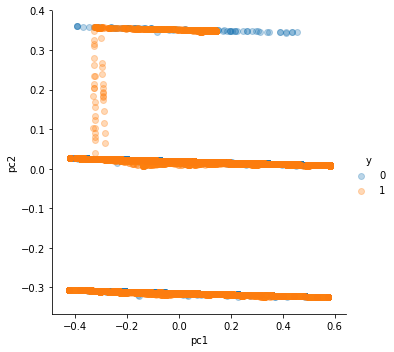

In [76]:
sns.lmplot('pc1', 'pc2', data=pca_smote_df, hue='y', scatter_kws={'alpha':0.3}, fit_reg=False)

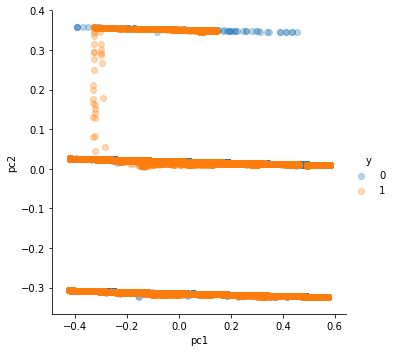

In [77]:
sns.lmplot('pc1', 'pc2', data=pca_smoteTomek_df, hue='y', scatter_kws={'alpha':0.3}, fit_reg=False)

### CONCLUSION IS THAT THE DATA IS CURRENTLY NOT SEPARATED ENOUGH. I need to add other features to separate the data

In [95]:
y = clean_train_data_v2.madePurchase
X = clean_train_data_v2.drop(columns=['logtransactionRevenue','madePurchase'])

In [96]:
X.head()

,visitNumber,isMobile,bounces,hits,newVisits,pageviews,isVideoAd,page,visitHour,monthDate,yearDate,dayDate,domain_(not_set),domain_.us,domain_.net,domain_.com,domain_.edu,domain_.ca,domain_.org,domain_.mx,os_Chrome OS,os_Macintosh,os_Linux,os_iOS,os_Windows,adContent_Google Merchandise Collection,adContent_(not_set),browser_Chrome,browser_Firefox,browser_Internet Explorer,browser_Edge,country_United States,country_Venezuela,country_Puerto Rico,country_Canada,city_Maracaibo,city_Ann Arbor,city_Cambridge,city_San Bruno,city_Chicago,city_Austin,city_Irvine,city_New York,city_Nashville,city_Jersey City,city_Boulder,city_Kirkland,city_Seattle,city_Oakland,city_Denver,city_Sunnyvale,city_San Francisco,city_Pittsburgh,city_Washington,city_Atlanta,city_Los Angeles,city_Mountain View,city_Minneapolis,city_San Antonio,city_Lake Oswego,city_Santa Clara,city_Cupertino,city_Salem,city_San Mateo,city_San Diego,city_Palo Alto,city_Fremont,city_Houston,city_Milpitas,city_Boston,city_Charlotte,city_San Jose,city_Philadelphia,city_Redwood City,city_Portland,city_Phoenix,city_(not_set),city_Toronto,city_Dallas,subContinent_Northern America,subContinent_Caribbean,campaign_AW - Dynamic Search Ads Whole Site,campaign_AW - Accessories,campaign_(not_set),region_Zulia,region_Nebraska,region_Michigan,region_Pichincha,region_Tennessee,region_Illinois,region_New York,region_Washington,region_Massachusetts,region_Colorado,region_South Carolina,region_Texas,region_Georgia,region_Missouri,region_Iowa,region_District of Columbia,region_California,region_Minnesota,region_Utah,region_Arizona,region_Pennsylvania,region_New Jersey,region_Indiana,region_Florida,region_Maryland,region_Connecticut,region_North Carolina,region_Virginia,region_Nevada,region_Ohio,region_Alberta,region_(not_set),region_Ontario,region_Oregon,source_mall.googleplex.com,source_dealspotr.com,source_mail.google.com,source_groups.google.com,source_phandroid.com,source_gdeals.googleplex.com,source_dfa,source_l.facebook.com,source_yahoo,source_google,source_bing,source_sites.google.com,source_(direct),source_facebook.com,referralPath_deal,referralPath_sign,referralPath_google,referralPath_merchandise,referralPath_store,referralPath_emails,referralPath_special,referralPath_coup,referralPath_stor,referralPath_mail,referralPath_com,referralPath_forum,referralPath_merch,referralPath_new,referralPath_url,referralPath_site,referralPath_mountain,referralPath_view,referralPath_php,referralPath_offer,referralPath_googletopia,referralPath_free,referralPath_stuff,referralPath_alphabet,referralPath_discount,keyword_qehscssdk,keyword_googl,keyword_merchandis,keyword_store,keyword_hzbaqlcbjwfgoh,keyword_remarket,keyword_content,keyword_target,keyword_zknv,channelGrouping_(Other),channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,deviceCategory_desktop,deviceCategory_mobile,deviceCategory_tablet,continent_(not_set),continent_Africa,continent_Americas,continent_Asia,continent_Europe,continent_Oceania,adNetworkType_(not_set),adNetworkType_Google Search,adNetworkType_Search partners,slot_(not_set),slot_RHS,slot_Top,dayNameDate_Friday,dayNameDate_Monday,dayNameDate_Saturday,dayNameDate_Sunday,dayNameDate_Thursday,dayNameDate_Tuesday,dayNameDate_Wednesday
0,1,0,1,1,1,1,1,0,15,9,2016,2,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
1,1,0,1,1,1,1,1,0,5,9,2016,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0

In [97]:
X_cols = X.columns
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X_cols)

In [98]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_scaled)

In [99]:
pca_data = pd.DataFrame(pca_data, columns=['pc1', 'pc2'])

In [100]:
pca_data = pd.concat([pca_data, y], axis=1)

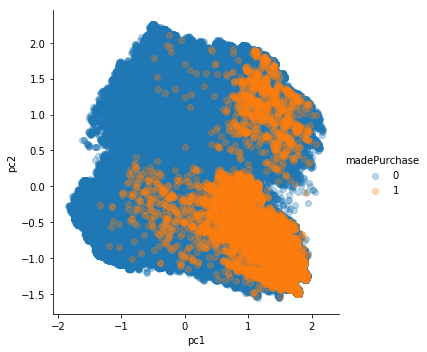

In [101]:
sns.lmplot('pc1', 'pc2', data=pca_data, hue='madePurchase', scatter_kws={'alpha':0.3}, fit_reg=False)

### 3D Plot

In [35]:
y = clean_train_data_v2.madePurchase
X = clean_train_data_v2.drop(columns=['logtransactionRevenue','madePurchase'])


X = X.sample(200000, random_state=0)
y = y.sample(200000, random_state=0)
y = y.reset_index()

X_cols = X.columns
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X_cols)

pca = PCA(n_components=3)
pca_data = pca.fit_transform(X_scaled)

pca_data = pd.DataFrame(pca_data, columns=['pc1', 'pc2', 'pc3'])

pca_data = pd.concat([pca_data, y], axis=1)

In [36]:
pca_data.head()

,pc1,pc2,pc3,index,madePurchase
0,-0.588506,1.586261,1.587258,813845,0
1,0.278207,1.542862,0.199514,787027,0
2,0.823539,-0.675522,-0.570536,368833,0
3,1.903822,-1.263847,-0.073935,625301,0
4,-0.913134,0.046159,-0.748463,188436,0


In [37]:
from mpl_toolkits import mplot3d

CPU times: user 1.04 s, sys: 86.8 ms, total: 1.13 s
Wall time: 1.04 s


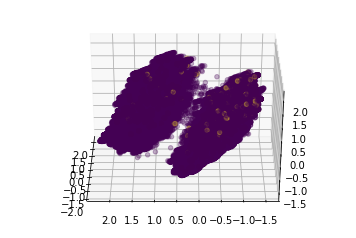

In [39]:
%%time
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(pca_data['pc1'], pca_data['pc2'], pca_data['pc3'], c=pca_data['madePurchase'], alpha = 0.3)

ax.view_init(30, 180)


CPU times: user 1.01 s, sys: 54.4 ms, total: 1.06 s
Wall time: 918 ms


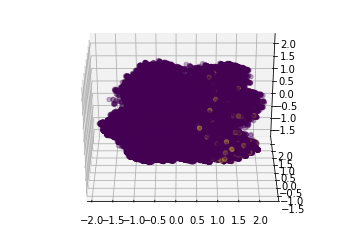

In [44]:
%%time
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(pca_data['pc1'], pca_data['pc2'], pca_data['pc3'], c=pca_data['madePurchase'], alpha = 0.3)

ax.view_init(30, 270)

CPU times: user 1.04 s, sys: 83 ms, total: 1.12 s
Wall time: 975 ms


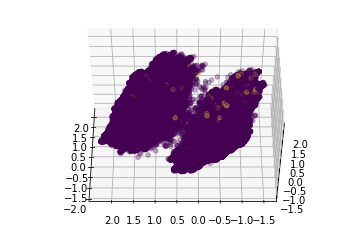

In [46]:
%%time
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(pca_data['pc1'], pca_data['pc2'], pca_data['pc3'], c=pca_data['madePurchase'], alpha = 0.3)
ax.view_init(50, 180)

CPU times: user 1.02 s, sys: 75.7 ms, total: 1.09 s
Wall time: 931 ms


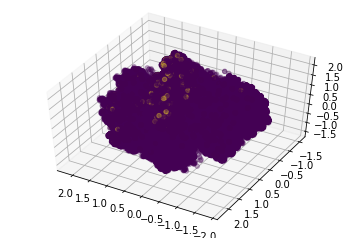

In [49]:
%%time
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(pca_data['pc1'], pca_data['pc2'], pca_data['pc3'], c=pca_data['madePurchase'], alpha = 0.3)
ax.view_init(50, 120)

CPU times: user 1.1 s, sys: 71.6 ms, total: 1.17 s
Wall time: 1.02 s


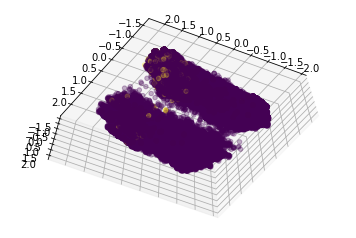

In [50]:
%%time
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(pca_data['pc1'], pca_data['pc2'], pca_data['pc3'], c=pca_data['madePurchase'], alpha = 0.3)
ax.view_init(110, 120)

# Boosting w Non-Aggregated Data

In [24]:
import lightgbm as lgb
# from xgboost import XGBRegressor
# from catboost import CatBoostRegressor
from sklearn.model_selection import GroupKFold, GridSearchCV

In [25]:
clean_train_data_v3.head()

,fullVisitorId,visitNumber,isMobile,bounces,hits,newVisits,pageviews,isVideoAd,page,visitHour,logtransactionRevenue,madePurchase,monthDate,yearDate,dayDate,domain_(not_set),domain_.us,domain_.net,domain_.com,domain_.edu,domain_.ca,domain_.org,domain_.mx,os_Chrome OS,os_Macintosh,os_Linux,os_iOS,os_Windows,adContent_Google Merchandise Collection,adContent_(not_set),browser_Chrome,browser_Firefox,browser_Internet Explorer,browser_Edge,country_United States,country_Venezuela,country_Puerto Rico,country_Canada,city_Maracaibo,city_Ann Arbor,city_Cambridge,city_San Bruno,city_Chicago,city_Austin,city_Irvine,city_New York,city_Nashville,city_Jersey City,city_Boulder,city_Kirkland,city_Seattle,city_Oakland,city_Denver,city_Sunnyvale,city_San Francisco,city_Pittsburgh,city_Washington,city_Atlanta,city_Los Angeles,city_Mountain View,city_Minneapolis,city_San Antonio,city_Lake Oswego,city_Santa Clara,city_Cupertino,city_Salem,city_San Mateo,city_San Diego,city_Palo Alto,city_Fremont,city_Houston,city_Milpitas,city_Boston,city_Charlotte,city_San Jose,city_Philadelphia,city_Redwood City,city_Portland,city_Phoenix,city_(not_set),city_Toronto,city_Dallas,subContinent_Northern America,subContinent_Caribbean,campaign_AW - Dynamic Search Ads Whole Site,campaign_AW - Accessories,campaign_(not_set),region_Zulia,region_Nebraska,region_Michigan,region_Pichincha,region_Tennessee,region_Illinois,region_New York,region_Washington,region_Massachusetts,region_Colorado,region_South Carolina,region_Texas,region_Georgia,region_Missouri,region_Iowa,region_District of Columbia,region_California,region_Minnesota,region_Utah,region_Arizona,region_Pennsylvania,region_New Jersey,region_Indiana,region_Florida,region_Maryland,region_Connecticut,region_North Carolina,region_Virginia,region_Nevada,region_Ohio,region_Alberta,region_(not_set),region_Ontario,region_Oregon,source_mall.googleplex.com,source_dealspotr.com,source_mail.google.com,source_groups.google.com,source_phandroid.com,source_gdeals.googleplex.com,source_dfa,source_l.facebook.com,source_yahoo,source_google,source_bing,source_sites.google.com,source_(direct),source_facebook.com,referralPath_deal,referralPath_sign,referralPath_google,referralPath_merchandise,referralPath_store,referralPath_emails,referralPath_special,referralPath_coup,referralPath_stor,referralPath_mail,referralPath_com,referralPath_forum,referralPath_merch,referralPath_new,referralPath_url,referralPath_site,referralPath_mountain,referralPath_view,referralPath_php,referralPath_offer,referralPath_googletopia,referralPath_free,referralPath_stuff,referralPath_alphabet,referralPath_discount,keyword_qehscssdk,keyword_googl,keyword_merchandis,keyword_store,keyword_hzbaqlcbjwfgoh,keyword_remarket,keyword_content,keyword_target,keyword_zknv,channelGrouping_(Other),channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,deviceCategory_desktop,deviceCategory_mobile,deviceCategory_tablet,continent_(not_set),continent_Africa,continent_Americas,continent_Asia,continent_Europe,continent_Oceania,adNetworkType_(not_set),adNetworkType_Google Search,adNetworkType_Search partners,slot_(not_set),slot_RHS,slot_Top,dayNameDate_Friday,dayNameDate_Monday,dayNameDate_Saturday,dayNameDate_Sunday,dayNameDate_Thursday,dayNameDate_Tuesday,dayNameDate_Wednesday
0,1131660440785968503,1,0,1,1,1,1,1,0,15,0.0,0,9,2016,2,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
1,377306020877927890,1,0,1,1,1,1,1,0,5,0.0,0,9,2016,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

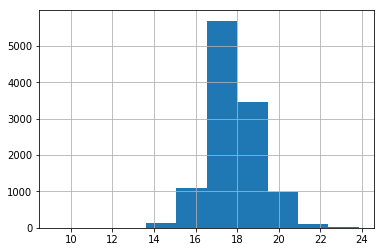

In [26]:
clean_train_data_v3['logtransactionRevenue'][clean_train_data_v3['logtransactionRevenue']>0].hist(bins = 10)

In [27]:
clean_train_data_v3['logtransactionRevenue'][clean_train_data_v3['logtransactionRevenue']>0].describe()

count    11514.000000
mean        17.823269
std          1.202505
min          9.210340
25%         17.031582
50%         17.716473
75%         18.493490
max         23.864375
Name: logtransactionRevenue, dtype: float64

In [28]:
excluded_features = ['fullVisitorId', 'logtransactionRevenue', 'madePurchase']

In [29]:
sample_train_cols = [_f for _f in clean_train_data_v3.columns if _f not in excluded_features]
sample_train = clean_train_data_v3[sample_train_cols].sample(200000, random_state=1)

sample_y = clean_train_data_v3['logtransactionRevenue'].sample(200000, random_state=1)

In [30]:
scaler = MinMaxScaler()
sample_train_scaled = scaler.fit_transform(sample_train)
sample_train_scaled = pd.DataFrame(sample_train_scaled, columns=sample_train_cols)

In [31]:
params={'learning_rate': 0.01,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 54,
        'verbose': 1,
        'bagging_fraction': 0.99,
        'feature_fraction': 0.99,
        "random_state":42,
        'max_depth': 15,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "bagging_frequency" : 5,
        'lambda_l2': 0.5,
        'lambda_l1': 0.5,
        'min_child_samples': 36
       }

In [32]:
# unscaled data
X_train, X_validate, y_train, y_validate = train_test_split(
    sample_train, sample_y, test_size=0.2, random_state=2)

model = lgb.LGBMRegressor(**params,n_estimators=1100)

model.fit(X_train, y_train,eval_set=[(X_validate, y_validate)], 
        early_stopping_rounds=50,verbose=100,eval_metric='rmse')

model.score(X_train, y_train)

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.7054
[200]	valid_0's rmse: 1.65132
[300]	valid_0's rmse: 1.63504
[400]	valid_0's rmse: 1.62982
Early stopping, best iteration is:
[399]	valid_0's rmse: 1.6298


0.463775246488492

In [33]:
# # SCALED DATA INSEAD
# X_train, X_validate, y_train, y_validate = train_test_split(
#     sample_train_scaled, sample_y, test_size=0.2, random_state=2)

# model = lgb.LGBMRegressor(**params,n_estimators=1100)

# model.fit(X_train, y_train,eval_set=[(X_validate, y_validate)], 
#         early_stopping_rounds=50,verbose=100,eval_metric='rmse')

# model.score(X_train, y_train)

In [34]:
train_predictions = model.predict(X_train)
validate_predictions = model.predict(X_validate)

In [35]:
train_predictions = pd.DataFrame(train_predictions, columns=['logtransactionRevenue'])
train_predictions['logtransactionRevenue'] = np.where(
    train_predictions['logtransactionRevenue']<9, 0, train_predictions['logtransactionRevenue'])

validate_predictions = pd.DataFrame(validate_predictions, columns=['logtransactionRevenue'])
validate_predictions['logtransactionRevenue'] = np.where(
    validate_predictions['logtransactionRevenue']<9, 0, validate_predictions['logtransactionRevenue'])

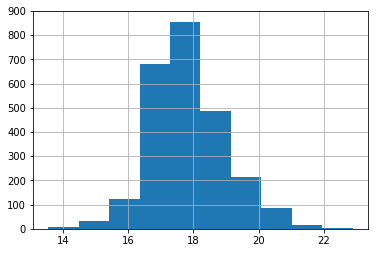

In [36]:
sample_y[sample_y>0].hist(bins=10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2d703a58>]],
      dtype=object)

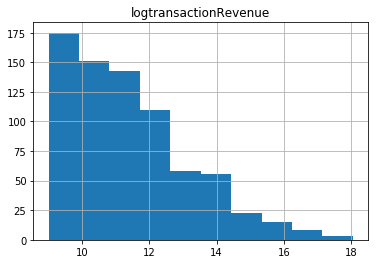

In [37]:
train_predictions[train_predictions['logtransactionRevenue']>0].hist(bins=10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c0e7e8be0>]],
      dtype=object)

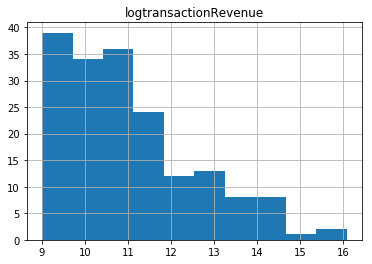

In [38]:
validate_predictions[validate_predictions['logtransactionRevenue']>0].hist(bins=10)

In [39]:
from sklearn.metrics import mean_squared_error

In [40]:
mean_squared_error(y_train, train_predictions) ** .5

1.7055374276958104

In [41]:
mean_squared_error(y_validate, validate_predictions) ** .5

1.8547855212261426

### Apply Boosting w Non-Aggregated Data on Entire Training Set

In [ ]:
excluded_features = ['fullVisitorId', 'logtransactionRevenue', 'madePurchase']

In [43]:
train_cols = [_f for _f in clean_train_data_v3.columns if _f not in excluded_features]
train_data = clean_train_data_v3[sample_train_cols]
y = clean_train_data_v3['logtransactionRevenue']

In [44]:
X_train, X_validate, y_train, y_validate = train_test_split(
    train_data, y, test_size=0.2, random_state=2)

model = lgb.LGBMRegressor(**params,n_estimators=1100)

model.fit(X_train, y_train,eval_set=[(X_validate, y_validate)], 
        early_stopping_rounds=50,verbose=100,eval_metric='rmse')

model.score(X_train, y_train)

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.71883
[200]	valid_0's rmse: 1.65518
[300]	valid_0's rmse: 1.63421
[400]	valid_0's rmse: 1.62467
[500]	valid_0's rmse: 1.62064
[600]	valid_0's rmse: 1.61876
[700]	valid_0's rmse: 1.61744
[800]	valid_0's rmse: 1.61633
[900]	valid_0's rmse: 1.61567
[1000]	valid_0's rmse: 1.61541
[1100]	valid_0's rmse: 1.6151
Did not meet early stopping. Best iteration is:
[1097]	valid_0's rmse: 1.6151


0.43251574595467557

In [45]:
train_predictions = model.predict(X_train)
validate_predictions = model.predict(X_validate)

In [46]:
train_predictions = pd.DataFrame(train_predictions, columns=['logtransactionRevenue'])
train_predictions['logtransactionRevenue'] = np.where(
    train_predictions['logtransactionRevenue']<9, 0, train_predictions['logtransactionRevenue'])

validate_predictions = pd.DataFrame(validate_predictions, columns=['logtransactionRevenue'])
validate_predictions['logtransactionRevenue'] = np.where(
    validate_predictions['logtransactionRevenue']<9, 0, validate_predictions['logtransactionRevenue'])

In [47]:
mean_squared_error(y_train, train_predictions) ** .5

1.7456518174267748

In [48]:
mean_squared_error(y_validate, validate_predictions) ** .5

1.8620015570643391

#### Predict with Test Dataset

In [56]:
clean_test_data.head()

,Unnamed: 0,channelGrouping,fullVisitorId,sessionId,visitNumber,deviceCategory,isMobile,continent,bounces,hits,newVisits,pageviews,adNetworkType,isVideoAd,page,slot,visitHour,dayNameDate,monthDate,yearDate,dayDate,domain_(not_set),domain_.us,domain_.net,domain_.com,domain_.edu,domain_.ca,domain_.org,domain_.mx,os_Chrome OS,os_Macintosh,os_Linux,os_iOS,os_Windows,adContent_Google Merchandise Collection,adContent_(not_set),browser_Chrome,browser_Firefox,browser_Internet Explorer,browser_Edge,country_United States,country_Venezuela,country_Puerto Rico,country_Canada,city_Maracaibo,city_Ann Arbor,city_Cambridge,city_San Bruno,city_Chicago,city_Austin,city_Irvine,city_New York,city_Nashville,city_Jersey City,city_Boulder,city_Kirkland,city_Seattle,city_Oakland,city_Denver,city_Sunnyvale,city_San Francisco,city_Pittsburgh,city_Washington,city_Atlanta,city_Los Angeles,city_Mountain View,city_Minneapolis,city_San Antonio,city_Lake Oswego,city_Santa Clara,city_Cupertino,city_Salem,city_San Mateo,city_San Diego,city_Palo Alto,city_Fremont,city_Houston,city_Milpitas,city_Boston,city_Charlotte,city_San Jose,city_Philadelphia,city_Redwood City,city_Portland,city_Phoenix,city_(not_set),city_Toronto,city_Dallas,subContinent_Northern America,subContinent_Caribbean,campaign_AW - Dynamic Search Ads Whole Site,campaign_AW - Accessories,campaign_(not_set),region_Zulia,region_Nebraska,region_Michigan,region_Pichincha,region_Tennessee,region_Illinois,region_New York,region_Washington,region_Massachusetts,region_Colorado,region_South Carolina,region_Texas,region_Georgia,region_Missouri,region_Iowa,region_District of Columbia,region_California,region_Minnesota,region_Utah,region_Arizona,region_Pennsylvania,region_New Jersey,region_Indiana,region_Florida,region_Maryland,region_Connecticut,region_North Carolina,region_Virginia,region_Nevada,region_Ohio,region_Alberta,region_(not_set),region_Ontario,region_Oregon,source_mall.googleplex.com,source_dealspotr.com,source_mail.google.com,source_groups.google.com,source_phandroid.com,source_gdeals.googleplex.com,source_dfa,source_l.facebook.com,source_yahoo,source_google,source_bing,source_sites.google.com,source_(direct),source_facebook.com,referralPath_deal,referralPath_sign,referralPath_google,referralPath_merchandise,referralPath_store,referralPath_emails,referralPath_special,referralPath_coup,referralPath_stor,referralPath_mail,referralPath_com,referralPath_forum,referralPath_merch,referralPath_new,referralPath_url,referralPath_site,referralPath_mountain,referralPath_view,referralPath_php,referralPath_offer,referralPath_googletopia,referralPath_free,referralPath_stuff,referralPath_alphabet,referralPath_discount,keyword_qehscssdk,keyword_googl,keyword_merchandis,keyword_store,keyword_hzbaqlcbjwfgoh,keyword_remarket,keyword_content,keyword_target,keyword_zknv
0,0,Organic Search,6167871330617112363,6167871330617112363_1508151024,2,desktop,0,Asia,0,4,0,4,(not_set),1,0,(not_set),10,Monday,10,2017,16,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,Organic Search,0643697640977915618,0643697640977915618_1508175522,1,desktop,0,Europe,0,5,1,5,(not_set),1,0,(not_set),17,Monday,10,2017,16,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,Organic Search,6059383810968229466,6059383810968229466_1508143220,1,desktop,0,Europe,0,7,1,7,(not_set),1,0,(not_set),8,Monday,10,2017,16,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,

In [57]:
clean_test_data['isMobile'] = clean_test_data['isMobile'].astype('int64')

In [58]:
test_id_col = clean_test_data['fullVisitorId']
clean_test_data_v1 = clean_test_data.drop(columns = ['fullVisitorId', 'sessionId', 'Unnamed: 0'])

In [59]:
clean_test_data_v2 = pd.get_dummies(clean_test_data_v1)

In [60]:
clean_test_data_v3 = pd.concat([test_id_col, clean_test_data_v2], axis = 1)

In [61]:
clean_test_data_agg = (clean_test_data_v3.groupby(['fullVisitorId']).agg('sum'))

In [62]:
clean_test_data_agg = clean_test_data_agg.reset_index()
clean_test_data_agg = clean_test_data_agg.drop(columns=['visitNumber', 'visitHour'])
clean_test_data_agg.head()

,fullVisitorId,isMobile,bounces,hits,newVisits,pageviews,isVideoAd,page,monthDate,yearDate,dayDate,domain_(not_set),domain_.us,domain_.net,domain_.com,domain_.edu,domain_.ca,domain_.org,domain_.mx,os_Chrome OS,os_Macintosh,os_Linux,os_iOS,os_Windows,adContent_Google Merchandise Collection,adContent_(not_set),browser_Chrome,browser_Firefox,browser_Internet Explorer,browser_Edge,country_United States,country_Venezuela,country_Puerto Rico,country_Canada,city_Maracaibo,city_Ann Arbor,city_Cambridge,city_San Bruno,city_Chicago,city_Austin,city_Irvine,city_New York,city_Nashville,city_Jersey City,city_Boulder,city_Kirkland,city_Seattle,city_Oakland,city_Denver,city_Sunnyvale,city_San Francisco,city_Pittsburgh,city_Washington,city_Atlanta,city_Los Angeles,city_Mountain View,city_Minneapolis,city_San Antonio,city_Lake Oswego,city_Santa Clara,city_Cupertino,city_Salem,city_San Mateo,city_San Diego,city_Palo Alto,city_Fremont,city_Houston,city_Milpitas,city_Boston,city_Charlotte,city_San Jose,city_Philadelphia,city_Redwood City,city_Portland,city_Phoenix,city_(not_set),city_Toronto,city_Dallas,subContinent_Northern America,subContinent_Caribbean,campaign_AW - Dynamic Search Ads Whole Site,campaign_AW - Accessories,campaign_(not_set),region_Zulia,region_Nebraska,region_Michigan,region_Pichincha,region_Tennessee,region_Illinois,region_New York,region_Washington,region_Massachusetts,region_Colorado,region_South Carolina,region_Texas,region_Georgia,region_Missouri,region_Iowa,region_District of Columbia,region_California,region_Minnesota,region_Utah,region_Arizona,region_Pennsylvania,region_New Jersey,region_Indiana,region_Florida,region_Maryland,region_Connecticut,region_North Carolina,region_Virginia,region_Nevada,region_Ohio,region_Alberta,region_(not_set),region_Ontario,region_Oregon,source_mall.googleplex.com,source_dealspotr.com,source_mail.google.com,source_groups.google.com,source_phandroid.com,source_gdeals.googleplex.com,source_dfa,source_l.facebook.com,source_yahoo,source_google,source_bing,source_sites.google.com,source_(direct),source_facebook.com,referralPath_deal,referralPath_sign,referralPath_google,referralPath_merchandise,referralPath_store,referralPath_emails,referralPath_special,referralPath_coup,referralPath_stor,referralPath_mail,referralPath_com,referralPath_forum,referralPath_merch,referralPath_new,referralPath_url,referralPath_site,referralPath_mountain,referralPath_view,referralPath_php,referralPath_offer,referralPath_googletopia,referralPath_free,referralPath_stuff,referralPath_alphabet,referralPath_discount,keyword_qehscssdk,keyword_googl,keyword_merchandis,keyword_store,keyword_hzbaqlcbjwfgoh,keyword_remarket,keyword_content,keyword_target,keyword_zknv,channelGrouping_(Other),channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,deviceCategory_desktop,deviceCategory_mobile,deviceCategory_tablet,continent_(not_set),continent_Africa,continent_Americas,continent_Asia,continent_Europe,continent_Oceania,adNetworkType_(not_set),adNetworkType_Content,adNetworkType_Google Search,adNetworkType_Search partners,slot_(not_set),slot_Google Display Network,slot_RHS,slot_Top,dayNameDate_Friday,dayNameDate_Monday,dayNameDate_Saturday,dayNameDate_Sunday,dayNameDate_Thursday,dayNameDate_Tuesday,dayNameDate_Wednesday
0,0000000259678714014,0,0,19,1,13,2,0,22,4034,56,2,0,0,0,0,0,0,0,0,2,0,0,0,0,2,2,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
1,0000049363351866189,0,3,3,1,3,3,0,27,6051,55,3,0,0,0,0,0,0,0,3,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [63]:
diff_cols = set(clean_train_data_v3.columns).difference(set(clean_test_data_v3.columns))
diff_cols

{'logtransactionRevenue', 'madePurchase'}

In [79]:
test_excluded_features = ['fullVisitorId', 'logtransactionRevenue', 'madePurchase', 'slot_Google Display Network',
                         'adNetworkType_Content']

In [80]:
test_cols = [_f for _f in clean_test_data_v3.columns if _f not in test_excluded_features]

In [81]:
print(set(test_cols).difference(set(train_cols)))
print(len(train_cols))
print(len(test_cols))

set()
196
196


In [82]:
test_data = clean_test_data_v3[test_cols]
test_data.shape

(803863, 196)

In [83]:
test_predictions = model.predict(test_data)

In [86]:
test_predictions = pd.DataFrame(test_predictions, columns=['logtransactionRevenue'])
test_predictions['logtransactionRevenue'] = np.where(
    test_predictions['logtransactionRevenue']<9, 0, test_predictions['logtransactionRevenue'])

In [90]:
test_predictions_v1 = pd.concat([test_id_col, test_predictions], axis=1)
test_predictions_agg = (test_predictions_v1.groupby(['fullVisitorId']).agg('sum'))
test_predictions_agg = test_predictions_agg.reset_index()
test_predictions_agg.head()

,fullVisitorId,logtransactionRevenue
0,0000000259678714014,0.0
1,0000049363351866189,0.0
2,0000053049821714864,0.0
3,0000059488412965267,0.0
4,0000085840370633780,0.0


In [91]:
test_predictions_v1.shape

(803863, 2)

In [92]:
test_predictions_agg.shape

(617242, 2)

In [93]:
test_predictions_agg.to_csv('/Users/josephcolaco/customer_revenue_prediction/data/test_predictions.csv', index=False)

# Boosting w Agg Data

In [77]:
excluded_features = ['fullVisitorId', 'logtransactionRevenue', 'madePurchase']

In [78]:
clean_train_data_agg_v1.head()

,fullVisitorId,isMobile,bounces,hits,newVisits,pageviews,isVideoAd,page,logtransactionRevenue,madePurchase,domain_(not_set),domain_.us,domain_.net,domain_.com,domain_.edu,domain_.ca,domain_.org,domain_.mx,os_Chrome OS,os_Macintosh,os_Linux,os_iOS,os_Windows,adContent_Google Merchandise Collection,adContent_(not_set),browser_Chrome,browser_Firefox,browser_Internet Explorer,browser_Edge,country_United States,country_Venezuela,country_Puerto Rico,country_Canada,city_Maracaibo,city_Ann Arbor,city_Cambridge,city_San Bruno,city_Chicago,city_Austin,city_Irvine,city_New York,city_Nashville,city_Jersey City,city_Boulder,city_Kirkland,city_Seattle,city_Oakland,city_Denver,city_Sunnyvale,city_San Francisco,city_Pittsburgh,city_Washington,city_Atlanta,city_Los Angeles,city_Mountain View,city_Minneapolis,city_San Antonio,city_Lake Oswego,city_Santa Clara,city_Cupertino,city_Salem,city_San Mateo,city_San Diego,city_Palo Alto,city_Fremont,city_Houston,city_Milpitas,city_Boston,city_Charlotte,city_San Jose,city_Philadelphia,city_Redwood City,city_Portland,city_Phoenix,city_(not_set),city_Toronto,city_Dallas,subContinent_Northern America,subContinent_Caribbean,campaign_AW - Dynamic Search Ads Whole Site,campaign_AW - Accessories,campaign_(not_set),region_Zulia,region_Nebraska,region_Michigan,region_Pichincha,region_Tennessee,region_Illinois,region_New York,region_Washington,region_Massachusetts,region_Colorado,region_South Carolina,region_Texas,region_Georgia,region_Missouri,region_Iowa,region_District of Columbia,region_California,region_Minnesota,region_Utah,region_Arizona,region_Pennsylvania,region_New Jersey,region_Indiana,region_Florida,region_Maryland,region_Connecticut,region_North Carolina,region_Virginia,region_Nevada,region_Ohio,region_Alberta,region_(not_set),region_Ontario,region_Oregon,source_mall.googleplex.com,source_dealspotr.com,source_mail.google.com,source_groups.google.com,source_phandroid.com,source_gdeals.googleplex.com,source_dfa,source_l.facebook.com,source_yahoo,source_google,source_bing,source_sites.google.com,source_(direct),source_facebook.com,referralPath_deal,referralPath_sign,referralPath_google,referralPath_merchandise,referralPath_store,referralPath_emails,referralPath_special,referralPath_coup,referralPath_stor,referralPath_mail,referralPath_com,referralPath_forum,referralPath_merch,referralPath_new,referralPath_url,referralPath_site,referralPath_mountain,referralPath_view,referralPath_php,referralPath_offer,referralPath_googletopia,referralPath_free,referralPath_stuff,referralPath_alphabet,referralPath_discount,keyword_qehscssdk,keyword_googl,keyword_merchandis,keyword_store,keyword_hzbaqlcbjwfgoh,keyword_remarket,keyword_content,keyword_target,keyword_zknv,channelGrouping_(Other),channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social,deviceCategory_desktop,deviceCategory_mobile,deviceCategory_tablet,continent_(not_set),continent_Africa,continent_Americas,continent_Asia,continent_Europe,continent_Oceania,adNetworkType_(not_set),adNetworkType_Google Search,adNetworkType_Search partners,slot_(not_set),slot_RHS,slot_Top,dayNameDate_Friday,dayNameDate_Monday,dayNameDate_Saturday,dayNameDate_Sunday,dayNameDate_Thursday,dayNameDate_Tuesday,dayNameDate_Wednesday,visitNumber
0,0000010278554503158,0,0,11,1,8,1,0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,0000020424342248747,0,0,17,1,13,1,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
clean_train_data_agg_v1 = clean_train_data_agg_v1.drop(columns=['monthDate', 'yearDate', 'dayDate'])

In [80]:
sample_train_cols = [_f for _f in clean_train_data_agg_v1.columns if _f not in excluded_features]
sample_train = clean_train_data_agg_v1[sample_train_cols].sample(200000, random_state=1)

sample_y = clean_train_data_agg_v1['logtransactionRevenue'].sample(200000, random_state=1)

# scaler = MinMaxScaler()
# sample_train_scaled = scaler.fit_transform(sample_train)
# sample_train_scaled = pd.DataFrame(sample_train_scaled, columns=sample_train_cols)

In [81]:
params={'learning_rate': 0.01,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 54,
        'verbose': 1,
        'bagging_fraction': 0.99,
        'feature_fraction': 0.99,
        "random_state":42,
        'max_depth': 15,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "bagging_frequency" : 5,
        'lambda_l2': 0.5,
        'lambda_l1': 0.5,
        'min_child_samples': 36
       }

In [82]:
%%time
# unscaled data
X_train, X_validate, y_train, y_validate = train_test_split(
    sample_train, sample_y, test_size=0.2, random_state=2)

CPU times: user 429 ms, sys: 140 ms, total: 570 ms
Wall time: 577 ms


In [83]:
model = lgb.LGBMRegressor(**params,n_estimators=1100)

model.fit(X_train, y_train,eval_set=[(X_validate, y_validate)], 
        early_stopping_rounds=50,verbose=100,eval_metric='rmse')

model.score(X_train, y_train)

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 2.34018
[200]	valid_0's rmse: 2.24472
[300]	valid_0's rmse: 2.21928
[400]	valid_0's rmse: 2.2175
Early stopping, best iteration is:
[362]	valid_0's rmse: 2.21608


0.5337086516692906

In [84]:
%%time
train_predictions = model.predict(X_train)
validate_predictions = model.predict(X_validate)

CPU times: user 6.75 s, sys: 803 ms, total: 7.55 s
Wall time: 3.71 s


In [85]:
train_predictions = pd.DataFrame(train_predictions, columns=['logtransactionRevenue'])
train_predictions['logtransactionRevenue'] = np.where(
    train_predictions['logtransactionRevenue']<9, 0, train_predictions['logtransactionRevenue'])

validate_predictions = pd.DataFrame(validate_predictions, columns=['logtransactionRevenue'])
validate_predictions['logtransactionRevenue'] = np.where(
    validate_predictions['logtransactionRevenue']<9, 0, validate_predictions['logtransactionRevenue'])

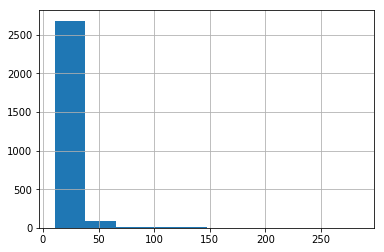

In [86]:
sample_y[sample_y>0].hist(bins=10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c15648978>]],
      dtype=object)

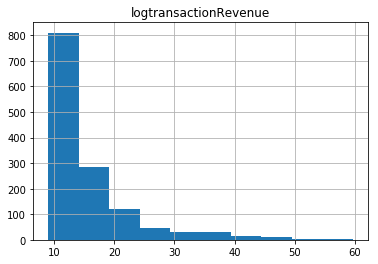

In [87]:
train_predictions[train_predictions['logtransactionRevenue']>0].hist(bins=10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1562eba8>]],
      dtype=object)

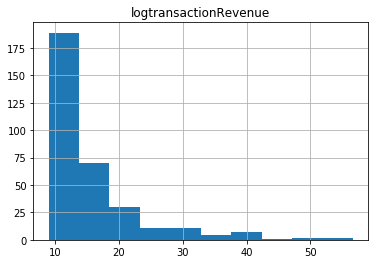

In [88]:
validate_predictions[validate_predictions['logtransactionRevenue']>0].hist(bins=10)

In [89]:
mean_squared_error(y_train, train_predictions) ** .5

2.0880430278051847

In [90]:
mean_squared_error(y_validate, validate_predictions) ** .5

2.3516183473220664

### Agg Feature Importance

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


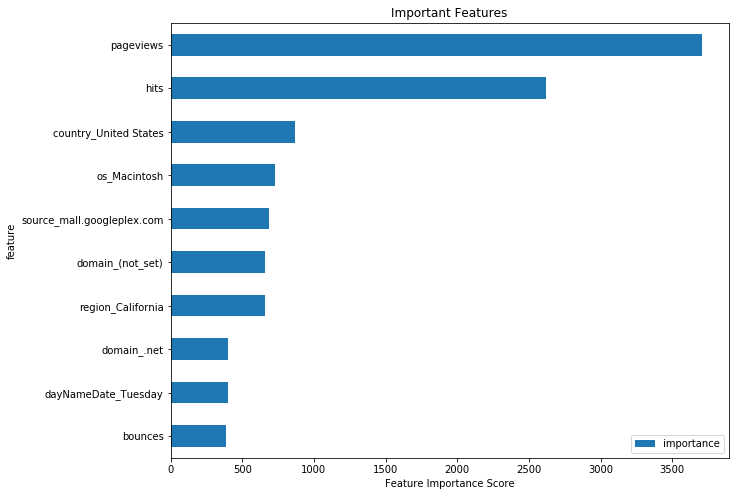

In [108]:
feat_imp = pd.DataFrame({'importance':model.feature_importances_})    
feat_imp['feature'] = sample_train_cols
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp_v1 = feat_imp.iloc[:10]

feat_imp_v1.sort_values(by='importance', inplace=True)
feat_imp_v1 = feat_imp_v1.set_index('feature', drop=True)
feat_imp_v1.plot.barh(title='Important Features', figsize=(10,8))
plt.xlabel('Feature Importance Score')
plt.show()

In [109]:
feat_imp=feat_imp.reset_index()

In [112]:
important_cols = feat_imp['feature'][feat_imp['importance']>0].values
important_cols

array(['pageviews', 'hits', 'country_United States', 'os_Macintosh',
       'source_mall.googleplex.com', 'domain_(not_set)',
       'region_California', 'domain_.net', 'dayNameDate_Tuesday',
       'bounces', 'dayNameDate_Friday', 'subContinent_Northern America',
       'browser_Chrome', 'dayNameDate_Monday', 'dayNameDate_Wednesday',
       'dayNameDate_Thursday', 'source_google', 'city_(not_set)',
       'channelGrouping_Organic Search', 'source_(direct)',
       'dayNameDate_Saturday', 'deviceCategory_desktop', 'city_Chicago',
       'isMobile', 'visitNumber', 'domain_.ca', 'isVideoAd',
       'channelGrouping_Referral', 'continent_Americas',
       'adContent_(not_set)', 'city_San Francisco', 'region_(not_set)',
       'os_Chrome OS', 'dayNameDate_Sunday', 'newVisits',
       'city_Mountain View', 'domain_.com', 'city_New York',
       'city_Sunnyvale', 'region_New York', 'os_Windows',
       'channelGrouping_Display', 'source_dfa',
       'channelGrouping_Paid Search', 'os_iOS', '

In [114]:
sample_train = clean_train_data_agg_v1[important_cols].sample(200000, random_state=1)
sample_y = clean_train_data_agg_v1['logtransactionRevenue'].sample(200000, random_state=1)

In [116]:
params={'learning_rate': 0.01,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 54,
        'verbose': 1,
        'bagging_fraction': 0.99,
        'feature_fraction': 0.99,
        "random_state":42,
        'max_depth': 15,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "bagging_frequency" : 5,
        'lambda_l2': 0.5,
        'lambda_l1': 0.5,
        'min_child_samples': 36
       }

# unscaled data
X_train, X_validate, y_train, y_validate = train_test_split(
    sample_train, sample_y, test_size=0.2, random_state=2)

model = lgb.LGBMRegressor(**params,n_estimators=1100)

model.fit(X_train, y_train,eval_set=[(X_validate, y_validate)], 
        early_stopping_rounds=50,verbose=100,eval_metric='rmse')

print('model score is:', model.score(X_train, y_train))

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 2.34182
[200]	valid_0's rmse: 2.24463
[300]	valid_0's rmse: 2.22044
[400]	valid_0's rmse: 2.21806
Early stopping, best iteration is:
[370]	valid_0's rmse: 2.21723
model score is: 0.535328118747014


In [117]:
%%time
train_predictions = model.predict(X_train)
validate_predictions = model.predict(X_validate)

CPU times: user 6.01 s, sys: 138 ms, total: 6.15 s
Wall time: 1.84 s


In [118]:
train_predictions = pd.DataFrame(train_predictions, columns=['logtransactionRevenue'])
train_predictions['logtransactionRevenue'] = np.where(
    train_predictions['logtransactionRevenue']<9, 0, train_predictions['logtransactionRevenue'])

validate_predictions = pd.DataFrame(validate_predictions, columns=['logtransactionRevenue'])
validate_predictions['logtransactionRevenue'] = np.where(
    validate_predictions['logtransactionRevenue']<9, 0, validate_predictions['logtransactionRevenue'])

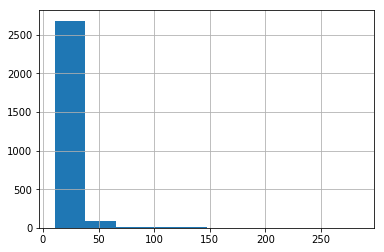

In [119]:
sample_y[sample_y>0].hist(bins=10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c167f1780>]],
      dtype=object)

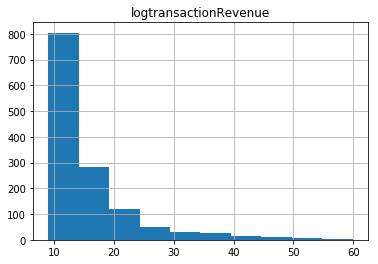

In [120]:
train_predictions[train_predictions['logtransactionRevenue']>0].hist(bins=10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c167f61d0>]],
      dtype=object)

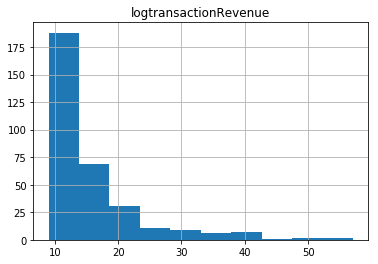

In [121]:
validate_predictions[validate_predictions['logtransactionRevenue']>0].hist(bins=10)

In [122]:
mean_squared_error(y_train, train_predictions) ** .5

2.086266315605266

In [123]:
mean_squared_error(y_validate, validate_predictions) ** .5

2.3504361884004736